
## Classification
    Two-stage model: yes/no on class 1 first and then 9-class classification for the rest. 
    
## Packages Installation
- tensorflow v1.5 (https://stackoverflow.com/questions/40416056/how-to-download-previous-version-of-tensorflow)
- If you have gpu: cuda v9.0; cudnn v7.0
- pytorch v0.4.0
- jupyter notebook >= 4.4.0
- numpy (newest)
- other packages as needed


In [1]:
##############################
#
# 09/03/18 setup
#
##############################
from __future__ import division
%matplotlib inline
%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy import array
import pandas as pd
import sklearn
import torch
import random
import seaborn as sn

# set random seed
# We need to set the cudnn to derministic mode so that we can get consistent result
# Yet, this will slow down the training :( It's a trade-off
# see https://discuss.pytorch.org/t/how-to-confugure-pytorch-to-get-deterministic-results/11797
# see https://discuss.pytorch.org/t/network-forward-backward-calculation-precision-error/17716/2
random_state = 100
np.random.seed(random_state)
torch.manual_seed(random_state)
random.seed(random_state)

In [2]:
# parameters
data_root_dir = 'C:/Users/janaki/Dropbox/bci/bill_grant_Fall2018/'
f_name = '442.csv'

# load the feature and data
df = pd.read_csv('%s/%s' %(data_root_dir, f_name), header=-1)

# define label and feature; convert it to ndarray
# adjust the label from 0 to 9
# y does not have to be one-hot embedding, i.e., if 10 class, then dim is 1000x10, can be 1000,
df_label = df.iloc[:,0]
df_f = df.iloc[:,1:]
X_raw = df_f.as_matrix()
y = df_label.as_matrix()-1

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [3]:
# X, y = make_classification(1000, 20, n_informative=10, random_state=0)
print(X_raw.shape)
print(y.shape)


(27675, 148)
(27675,)


In [4]:
"""
Prepare the datasets for 2-stage classificaton: yes/no class 1 and then 9-class classification for the rest. 

y_major: yes/no major class (1st stage)
y_minor: 9-class classification (2nd stage)
"""

def get_dataset(X_raw, y):
    # get the class 1-9
    minor_class_index = np.where(y>0)
    X_minor = np.squeeze(X_raw[minor_class_index,:])
    y_minor = y[minor_class_index]


    # get the majority class 0
    major_class_index = np.where(y==0)
    X_major = np.squeeze(X_raw[major_class_index,:])
    y_major = y[major_class_index]


    # prepare the major class for 1st stage training
    s = X_minor.shape
    r_index = random.sample(range(X_major.shape[0]),s[0])
    #r_index = range(X_major.shape[0])
    X_major = X_major[r_index,:]
    y_major = y_major[r_index]


    # create the major class set
    X_tmp = np.copy(X_minor)
    y_tmp = np.ones(X_minor.shape[0])
    X_major = np.concatenate((X_major,X_tmp))
    y_major = np.concatenate((y_major,y_tmp))


    # adjust the minor class set label
    y_minor = y_minor - 1
    return X_minor, y_minor, X_major, y_major


# check
X_minor, y_minor, X_major, y_major = get_dataset(X_raw,y)
print(X_minor.shape)
print(y_minor.shape)
print(X_major.shape)
print(y_major.shape)




(5119, 148)
(5119,)
(10238, 148)
(10238,)


In [5]:
    df_label = pd.DataFrame(y_minor)
    df_label = df_label.iloc[:,0]
    
    counts = df_label.value_counts().sort_index()
    print(counts)

0      66
1      92
2     571
3     820
4     297
5     210
6    1539
7     733
8     791
Name: 0, dtype: int64


In [6]:
import pandas as pd
# calculate class ratio for loss calculation because it is imbalanced

def get_weight_balance(y):
    """
    Calculate the class ratio.
    """
    df_label = pd.DataFrame(y)
    df_label = df_label.iloc[:,0]
    
    counts = df_label.value_counts().sort_index()
    counts_np = counts.as_matrix()
    max_val = np.max(np.abs(counts_np),axis=0)

    class_weight = np.max(np.abs(counts_np),axis=0)/counts_np
    class_weight = class_weight.tolist()
    
    return class_weight

weight_minor = get_weight_balance(y_minor)
weight_major = get_weight_balance(y_major)

# # check
print(y_major)
print(weight_minor)
# print(len(weight_major))
# print(len(weight_minor))

[0. 0. 0. ... 1. 1. 1.]
[23.318181818181817, 16.72826086956522, 2.6952714535901925, 1.8768292682926828, 5.181818181818182, 7.328571428571428, 1.0, 2.0995907230559343, 1.945638432364096]


C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [7]:
"""
Define the CNN model.
"""
from torch import nn
import torch.nn.functional as F

class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=F.relu, num_output=11):
        super(MyModule, self).__init__()
        self.conv1d_1 = nn.Conv1d(1, 40, kernel_size=147)
        self.pool = nn.MaxPool1d(2, padding = 0)
        
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        
        self.dense0 = nn.Linear(40, num_units)
        self.dense0_bn = nn.BatchNorm1d(10)
        self.dense1 = nn.Linear(num_units, 10)
        self.dense1_bn = nn.BatchNorm1d(10)
        self.output = nn.Linear(10, num_output)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.conv1d_1(X))
        X= self.pool(X)
        X = X.view(-1, self._get_element_count(X))     
        X = self.nonlin(self.dense0_bn(self.dense0(X)))
        X = self.nonlin(self.dense1_bn(self.dense1(X)))
        X = self.output(X)
        #X = F.softmax(self.output(X), dim=-1)
        return X
    
    def _get_element_count(self,x):
        """
        Get the total number of elements in a layer output (not consider the batch level)
        """
        x_dim = list(x.size())[1:]
        return reduce(lambda x, y: x*y, x_dim)


In [8]:
def xy_preprocess(X_raw,y):
    # define the data
    X = X_raw.astype(np.float32) #1000x148
    y = y.astype(np.int64) #1000x1

    # add a dummy dimension to X to make it having channel
    X = np.expand_dims(X, axis=1) #1000x1x148
    
    return X, y

In [9]:
def convert_to_proba(y_proba):
    # convert it into probabilities
    y_proba = torch.from_numpy(y_proba)
    y_proba = F.softmax(y_proba, dim=-1)
    y_proba = y_proba.numpy()
    return y_proba

In [10]:
"""
Train the model
"""
from sklearn.datasets import make_classification
from skorch import NeuralNetClassifier
import torch.optim as optim
import torch
from functools import reduce

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# if data_type == 'major':
#     X_raw = X_major
#     y = y_major
#     class_weight = weight_major
#     num_output = 2
# else:
#     X_raw = X_minor
#     y = y_minor    
#     class_weight = weight_minor
#     num_output = 9

# adjustable parameters
num_folds = 123
batch_size = 100
major_weights=[20]

# fixed parameters
today_date = '03082019'
criterion = nn.CrossEntropyLoss

#k-fold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)

# cross-validation
y_probas = np.zeros(shape=(X_raw.shape[0],10))
fold_i = 0

for major_weight in major_weights:
    for train_index, test_index in skf.split(X_raw, y):
        # fold
        fold_i = fold_i + 1
        print('==========Fold:%s==========' %fold_i)

        # data split
        X_train, X_test = X_raw[train_index], X_raw[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # check label values distribution
    #         unique_elements, counts_elements = np.unique(y_test, return_counts=True)
    #         print(unique_elements)
    #         print(counts_elements)
    #         dasda

        # split the data into major (2-class) and minor (9-class) set
        X_minor, y_minor, X_major, y_major = get_dataset(X_train, y_train)

        # preprocess
        X_major, y_major = xy_preprocess(X_major,y_major)
        X_minor, y_minor = xy_preprocess(X_minor,y_minor)
        X_test, y_test = xy_preprocess(X_test, y_test)

        # ======================================== major classifier
        # define the weight of each class
        # https://discuss.pytorch.org/t/passing-the-weights-to-crossentropyloss-correctly/14731
        class_weight = get_weight_balance(y_major)
        class_weight[1] = major_weight
        class_weight = torch.FloatTensor(class_weight)
        # define the network
        num_output = 2
        max_epochs = 20
        net_major = NeuralNetClassifier(
                MyModule,
                max_epochs=max_epochs,
                lr=0.01,
                criterion=criterion,
                train_split=None,
                optimizer=optim.Adam,
                batch_size=batch_size,
                warm_start=False,
                iterator_train__shuffle=True,  
                criterion__weight=class_weight,
                module__num_output=num_output,
        )
        net_major.fit(X_major, y_major)


        # ======================================== minor classifier
        # define the weight of each class
        # https://discuss.pytorch.org/t/passing-the-weights-to-crossentropyloss-correctly/14731
        class_weight = get_weight_balance(y_minor)
        class_weight = torch.FloatTensor(class_weight)

        # define the network
        num_output = 9
        max_epochs = 30
        net_minor = NeuralNetClassifier(
                MyModule,
                max_epochs=max_epochs,
                lr=0.01,
                criterion=criterion,
                train_split=None,
                optimizer=optim.Adam,
                batch_size=batch_size,
                warm_start=False,
                iterator_train__shuffle=True,  
                criterion__weight=class_weight,
                module__num_output=num_output,
        )
        net_minor.fit(X_minor, y_minor)
        
        # ======================================== prediction

        # predict
        y_proba_major = convert_to_proba(net_major.predict_proba(X_test))
        y_proba_minor = convert_to_proba(net_minor.predict_proba(X_test))


        # combine
        # combine prob
        for i in range(0, y_proba_minor.shape[0]):
            y_proba_minor[i,:] = y_proba_minor[i,:] * y_proba_major[i,1]
        y_proba_major = y_proba_major[:,0]
        y_proba_major = np.expand_dims(y_proba_major, axis=1)
        y_proba =  np.concatenate((y_proba_major, y_proba_minor), 1)

        # assign probs to certain row
        y_probas[test_index,:] = y_proba
    ############################################################################
            

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 66 members, which is too few. The minimum number of members in any class cannot be less than n_splits=123.
  % (min_groups, self.n_splits)), Warning)


==========Fold:1==========


C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


  epoch    train_loss     dur
-------  ------------  ------
      1        0.2550  0.5994
      2        0.1679  0.4741
      3        0.1550  0.4691
      4        0.1468  0.4831
      5        0.1397  0.4731
      6        0.1361  0.4846
      7        0.1290  0.4756
      8        0.1270  0.4911
      9        0.1189  0.4766
     10        0.1143  0.4746
     11        0.1111  0.4686
     12        0.1105  0.4891
     13        0.1073  0.4851
     14        0.1045  0.4776
     15        0.1026  0.4821
     16        0.1025  0.4891
     17        0.0994  0.4542
     18        0.0945  0.4901
     19        0.0928  0.4621
     20        0.0927  0.4796
  epoch    train_loss     dur
-------  ------------  ------
      1        2.0255  0.2376
      2        1.5949  0.2500
      3        1.2831  0.2376
      4        1.0548  0.2535
      5        0.9754  0.2974
      6        0.8132  0.2371
      7        0.6797  0.2535
      8        0.6825  0.2301
      9        0.6025  0.2326
     10   

In [15]:
    """
    Evaluate the performance
    """
    from sklearn.metrics import confusion_matrix

    # get the y_pred
    y_preds = np.argmax(y_probas,axis=1)

    # calculation the confusion matrix
    # row: true label
    # col: predicted value
    cm = np.array(confusion_matrix(y,y_preds))
    print(df.iloc[:,0].value_counts())
    freq = np.array([22556,66, 92, 571,820,297,210,1539,733,791])
    #cm = np.transpose(cm)
    print('confusion matrix!')
    print(cm)

1     22556
8      1539
5       820
10      791
9       733
4       571
6       297
7       210
3        92
2        66
Name: 0, dtype: int64
confusion matrix!
[[12219   195   229  1486  1798   544   283  2193  1881  1728]
 [    5    46     0     3     4     2     0     3     0     3]
 [    4     0    76     0     2     0     7     3     0     0]
 [   16     5     4   432    17     4     2    31    40    20]
 [   26    15     2    38   577    22     9    61    33    37]
 [    9     2     1     0    11   245     0    11    10     8]
 [    2     0    15     1     8     2   176     5     1     0]
 [   28     6    11    85    99    35    27  1141    43    64]
 [   28     1     0    41    21    15     3    23   567    34]
 [   27     4     2    15    21    11     2    52    52   605]]


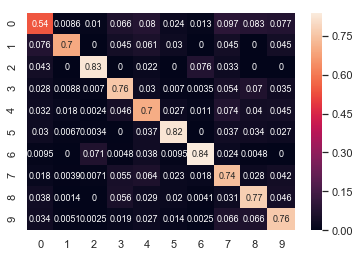

In [16]:
    # export to csv`
    df_cm = pd.DataFrame(cm/freq[:,None])
    sn.set(font_scale=1)
    accuracies = sn.heatmap(df_cm, annot=True, annot_kws={"size":9})
    figure = accuracies.get_figure()
    figure.savefig('Subject1_cnn.png')